In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d xainano/handwrittenmathsymbols

Dataset URL: https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols
License(s): CC0-1.0
 99% 341M/343M [00:02<00:00, 187MB/s]
100% 343M/343M [00:02<00:00, 153MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/handwrittenmathsymbols.zip",'r')
zip.extractall("/content")
zip.close()

In [4]:
import os

# Check the contents of the extracted directory
extracted_dir = "/content/extracted_images"  # Update this path if necessary
print(os.listdir(extracted_dir))

['+', '0', '(', '!', ',', '-', ')']


In [5]:
import os

# Define the path to the extracted directory
extracted_dir = "/content/extracted_images"  # Update this path if the folder name differs

# List the contents of the extracted directory
print(os.listdir(extracted_dir))

['+', '0', '(', '!', ',', '-', ')']


In [6]:
import os
import random

# Define the path to your dataset directory
dataset_dir = "/content/extracted_images"
target_count = 4000  # The number of images you want to keep in each folder

# Loop through each folder in the dataset directory
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)

    # Check if the folder_path is a directory
    if os.path.isdir(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)

        # If the number of files exceeds the target count
        if len(files) > target_count:
            # Randomly select target_count files to keep
            files_to_keep = random.sample(files, target_count)

            # Identify files to remove
            files_to_remove = [file for file in files if file not in files_to_keep]

            # Remove the files that are not needed
            for file_name in files_to_remove:
                file_path = os.path.join(folder_path, file_name)
                os.remove(file_path)

            print(f'Reduced {folder} to {target_count} images.')

print("Image reduction process completed.")


Reduced + to 4000 images.
Reduced 0 to 4000 images.
Reduced ( to 4000 images.
Reduced - to 4000 images.
Reduced ) to 4000 images.
Image reduction process completed.


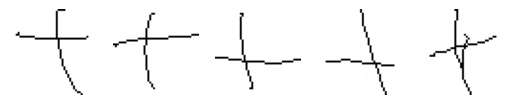

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# List to store all image file paths
all_images = []

# Loop through each symbol directory and collect image paths
for symbol in os.listdir(extracted_dir):
    symbol_path = os.path.join(extracted_dir, symbol)
    if os.path.isdir(symbol_path):  # Ensure it's a directory
        for img_file in os.listdir(symbol_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(symbol_path, img_file))

# Display the first few images
for i, img_path in enumerate(all_images[:5]):
    img = Image.open(img_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

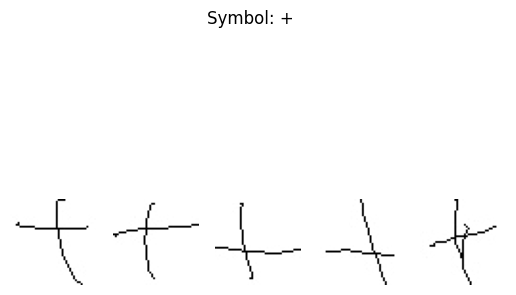

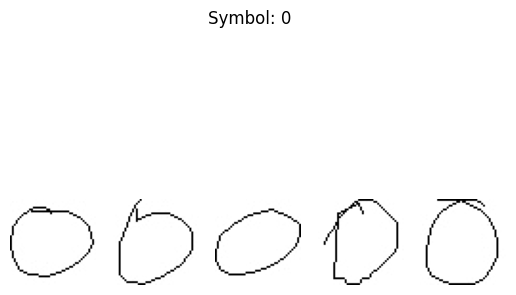

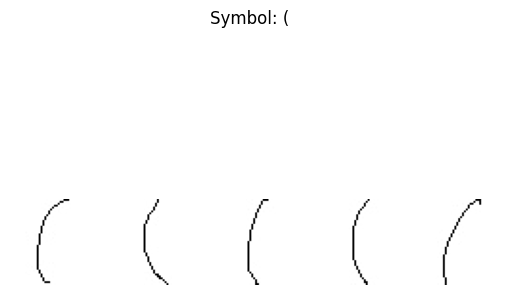

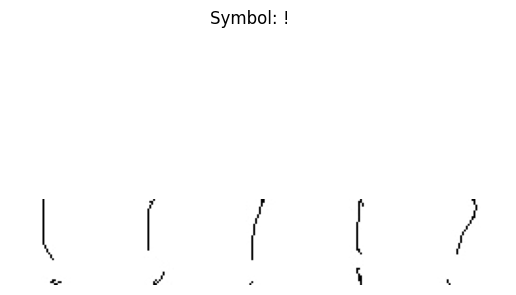

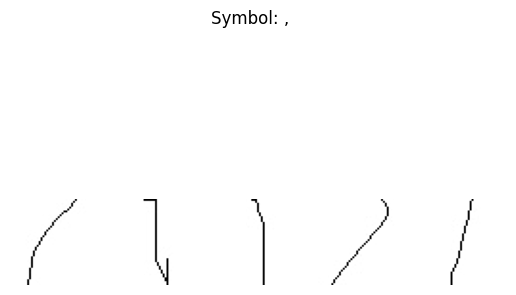

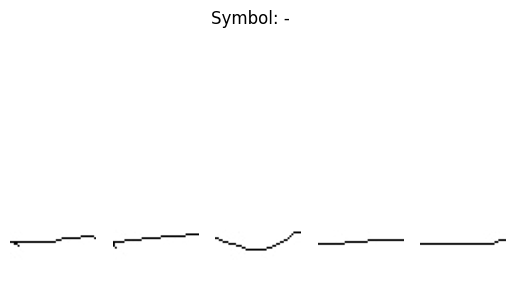

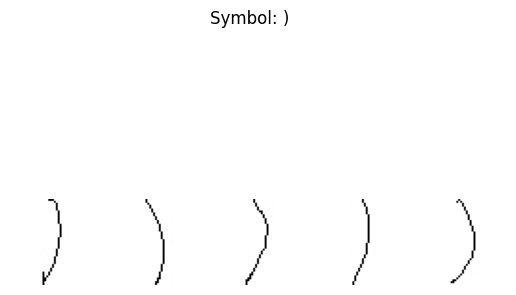

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the directory where the images are extracted
extracted_dir = "/content/extracted_images"  # Update this path if necessary

# Loop through each symbol directory and display up to 5 images from each
for symbol in os.listdir(extracted_dir):
    symbol_path = os.path.join(extracted_dir, symbol)
    if os.path.isdir(symbol_path):  # Ensure it's a directory
        image_files = [os.path.join(symbol_path, img_file)
                       for img_file in os.listdir(symbol_path)
                       if img_file.endswith(('.png', '.jpg', '.jpeg'))]

        # Display up to 5 images from this directory
        for i, img_path in enumerate(image_files[:5]):
            img = Image.open(img_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Symbol: {symbol}')  # Title indicating the symbol
        plt.show()


In [9]:
import cv2
import numpy as np    #importing libraries
import os
import pandas as pd

In [10]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)      # Preprocessing - Invert and Binarize the Image

    # Invert the image colors
    inverted_image = cv2.bitwise_not(image)

    # Convert to binary image
    _, binary_image = cv2.threshold(inverted_image, 127, 255, cv2.THRESH_BINARY)

    return binary_image


In [11]:
def get_max_bounding_rect(binary_image):
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to track the maximum area and corresponding rectangle
    max_area = 0
    max_rect = None

    for contour in contours:                               #Extract Contours and Find the Maximum Area Bounding Rectangle
        # Get bounding rectangle for the contour
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h

        # Check if this is the largest area so far
        if area > max_area:
            max_area = area
            max_rect = (x, y, w, h)

    return max_rect


In [12]:
def extract_features(binary_image, max_rect):
    x, y, w, h = max_rect
    # Crop the image using the bounding rectangle
    cropped_image = binary_image[y:y+h, x:x+w]

    # Resize the image to 28x28                             #Resize the Bounding Rectangle and Extract Features
    resized_image = cv2.resize(cropped_image, (28, 28))

    # Flatten the image to a 784x1 vector
    flattened_image = resized_image.flatten()

    return flattened_image

In [13]:
def process_dataset(dataset_dir, output_csv):
    data = []

    # Define label mapping
    label_mapping = {
        "0": 0, "1": 1, "2": 2, "3": 3, "4": 4,
        "5": 5, "6": 6, "7": 7, "8": 8, "9": 9,                      #Assign Labels and Compile the Dataset
        "-": 10, "+": 11, "times": 12
    }

    # Loop through each folder (each symbol/digit)
    for label_name in os.listdir(dataset_dir):
        folder_path = os.path.join(dataset_dir, label_name)

        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)

                # Preprocess the image
                binary_image = preprocess_image(image_path)

                # Get the maximum area bounding rectangle
                max_rect = get_max_bounding_rect(binary_image)

                if max_rect:
                    # Extract features from the image
                    features = extract_features(binary_image, max_rect)

                    # Assign label based on the folder name
                    label = label_mapping.get(label_name, -1)

                    # Combine features and label
                    data.append(np.append(features, label))

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Save to CSV
    df.to_csv(output_csv, index=False, header=False)
    print(f"Dataset saved to {output_csv}")

# Process the dataset and save to a CSV file
process_dataset("/content/extracted_images", "dataset.csv")


Dataset saved to dataset.csv


In [14]:
data=pd.read_csv('/content/dataset.csv')

In [15]:
data

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.690,0.691,0.692,0.693,30,77,159,0.694,0.695,11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
1,0,0,0,0,0,0,0,0,209,59,...,0,0,0,0,0,0,0,0,0,11
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,255,0,0,0,11
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4,0,0,0,0,0,0,0,0,0,0,...,156,13,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23200,0,0,22,67,111,155,178,178,178,178,...,0,0,0,0,0,0,0,0,0,-1
23201,178,163,120,77,44,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
23202,255,255,177,96,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
23203,178,178,178,178,178,178,170,84,17,0,...,0,13,165,99,28,0,0,0,0,-1


In [16]:
data.head(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.690,0.691,0.692,0.693,30,77,159,0.694,0.695,11
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
1,0,0,0,0,0,0,0,0,209,59,...,0,0,0,0,0,0,0,0,0,11
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,255,0,0,0,11
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
4,0,0,0,0,0,0,0,0,0,0,...,156,13,0,0,0,0,0,0,0,11


In [17]:
data.tail(5)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.690,0.691,0.692,0.693,30,77,159,0.694,0.695,11
23200,0,0,22,67,111,155,178,178,178,178,...,0,0,0,0,0,0,0,0,0,-1
23201,178,163,120,77,44,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
23202,255,255,177,96,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
23203,178,178,178,178,178,178,170,84,17,0,...,0,13,165,99,28,0,0,0,0,-1
23204,178,178,178,178,167,131,95,64,36,8,...,0,0,0,0,0,0,0,0,0,-1


In [18]:
data.shape

(23205, 785)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23205 entries, 0 to 23204
Columns: 785 entries, 0 to 11
dtypes: int64(785)
memory usage: 139.0 MB


In [20]:
data.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.690,0.691,0.692,0.693,30,77,159,0.694,0.695,11
count,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.00000,...,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.000000,23205.00000,23205.000000,23205.000000
mean,47.256109,44.716397,41.612971,38.666193,36.854730,35.743762,35.658393,36.492739,38.333764,40.65292,...,32.835984,31.376169,30.461969,29.846930,30.037363,30.414393,30.873217,31.94122,32.472269,3.136522
std,93.091969,90.167464,84.542623,80.988107,78.742947,77.538585,77.707171,78.263595,79.787584,80.99586,...,72.271249,71.167958,71.084436,71.084067,72.362990,74.088377,75.408319,78.99763,80.256643,5.360635
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,19.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,10.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,11.000000


In [21]:
data.isnull().sum()

,0
0,0
0.1,0
0.2,0
0.3,0
0.4,0
...,...
77,0
159,0
0.694,0
0.695,0


In [22]:
data.count()

,0
0,23205
0.1,23205
0.2,23205
0.3,23205
0.4,23205
...,...
77,23205
159,23205
0.694,23205
0.695,23205


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape

In [24]:

# Load the dataset
data = pd.read_csv("dataset.csv", header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


In [25]:

# Reshape X to be suitable for CNN input
X = X.reshape(-1, 28, 28, 1)  # 28x28 image with 1 channel

In [26]:
# Normalize the data
X = X / 255.0

In [27]:
# One-hot encode the labels
y = tf.keras.utils.to_categorical(y, num_classes=13)

In [28]:
# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(13, activation='softmax')  # 13 classes for digits and symbols
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9001 - loss: 0.2804 - val_accuracy: 0.9858 - val_loss: 0.0631
Epoch 2/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9866 - loss: 0.0404 - val_accuracy: 0.9565 - val_loss: 0.1303
Epoch 3/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9906 - loss: 0.0270 - val_accuracy: 0.8925 - val_loss: 0.3097
Epoch 4/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9929 - loss: 0.0193 - val_accuracy: 0.9347 - val_loss: 0.2148
Epoch 5/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9938 - loss: 0.0169 - val_accuracy: 0.9298 - val_loss: 0.2139
Epoch 6/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9911 - loss: 0.0241 - val_accuracy: 0.9102 - val_loss: 0.3209
Epoch 7/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9917 - loss: 0.0209 - val_accuracy: 0.9272 - val_loss: 0.2758
Epoch 8/10
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9929 - loss: 0.0168 - val_accuracy: 0

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,718,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,217,641 (54.24 MB)

 Trainable params: 4,739,213 (18.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,478,428 (36.16 MB)

In [ ]:
model.save('handwritten_math_symbols_model.h5')

In [ ]:
from google.colab import files
files.download('handwritten_math_symbols_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>